In [1]:
import torch

import triton
import triton.language as tl

In [2]:
DEVICE = triton.runtime.driver.active.get_active_torch_device()

In [3]:
@triton.jit
def add_kernel(x_ptr,
               y_ptr,
               output_ptr,
               n_elements,
               BLOCK_SIZE: tl.constexpr):

  pid = tl.program_id(axis=0) # this is like x.blockIdx * x.blockDim + x.threadIdx ?
  block_start= pid * BLOCK_SIZE
  offsets = block_start + tl.arange(0,BLOCK_SIZE)
  # we create an entire guard array
  mask = offsets < n_elements
  x = tl.load(x_ptr + offsets,mask=mask)
  y = tl.load(y_ptr + offsets,mask=mask)
  output = x +y
  tl.store(output_ptr + offsets, output, mask=mask)


def add(x:torch.Tensor,y:torch.Tensor) -> torch.Tensor:

  output = torch.empty_like(x)

  assert x.device == DEVICE and y.device == DEVICE and output.device == DEVICE

  n_elements = output.numel()
  #cdiv gives ceiling division e.g int(n_elements / block_size) +1
  grid = lambda meta: (triton.cdiv(n_elements,meta['BLOCK_SIZE']), )
  add_kernel[grid](x,y,output,n_elements,BLOCK_SIZE=1024)
  return output


In [4]:
torch.manual_seed(0)

size = 76783

x = torch.rand(size,device=DEVICE)
y = torch.rand(size,device=DEVICE)

output_torch = x + y
output_triton = add(x,y)

max(torch.abs(output_torch - output_triton))



tensor(0., device='cuda:0')

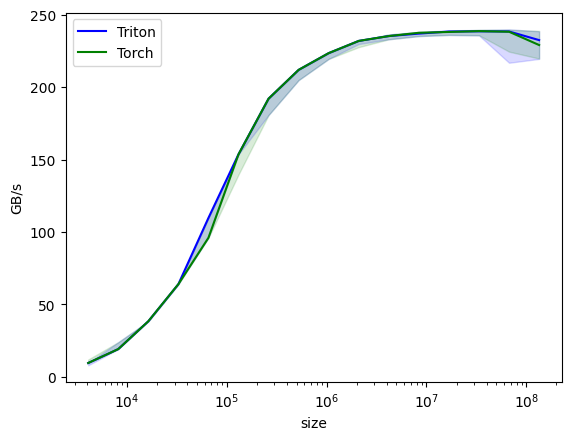

vector-add-performance:
           size      Triton       Torch
0        4096.0    9.600000    9.600000
1        8192.0   19.200000   19.200000
2       16384.0   38.400001   38.400001
3       32768.0   63.999998   63.999998
4       65536.0  109.714284   96.000000
5      131072.0  153.600004  153.600004
6      262144.0  192.000000  192.000000
7      524288.0  211.862064  211.862064
8     1048576.0  223.418180  223.418180
9     2097152.0  231.849058  231.849058
10    4194304.0  235.177028  235.177028
11    8388608.0  236.877115  237.449270
12   16777216.0  238.312729  238.024212
13   33554432.0  238.457249  238.601945
14   67108864.0  238.348842  238.168383
15  134217728.0  232.397160  228.996723


In [5]:
@triton.testing.perf_report(
    triton.testing.Benchmark(
        x_names=['size'],
        x_vals=[2**i for i in range (12,28,1)],
        x_log = True,
        line_arg ='provider',
        line_vals = ['triton','torch'],
        line_names = ['Triton','Torch'],
        styles= [('blue','-'),('green','-')],
        ylabel='GB/s',
        plot_name='vector-add-performance',
        args={}
    )
)
def benchmark(size,provider):
  x = torch.randn(size,device=DEVICE,dtype=torch.float32)
  y = torch.randn(size,device=DEVICE,dtype=torch.float32)
  quantiles=[0.5,0.2,0.8]
  if provider=='torch':
    ms,min_ms,max_ms = triton.testing.do_bench(lambda: x+y, quantiles=quantiles)
  if provider=='triton':
    ms,min_ms,max_ms = triton.testing.do_bench(lambda: add(x,y), quantiles=quantiles)
  gbps = lambda ms: 3 * x.numel() * x.element_size() * 1e-9 / (ms* 1e-3)
  return gbps(ms),gbps(max_ms),gbps(min_ms)

benchmark.run(print_data=True,show_plots=True)